In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from glob import glob
import pandas as pd
from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import find_contours
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte

### ABCF 이미지 로드

In [2]:
def show_image(image, title='Image'):
    if image is not None:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

In [3]:
def show_image_new(image, title='Image'):
    # 이미지를 uint8 형식으로 변환
    image_uint8 = (image * 255).astype(np.uint8)
    
    # 이미지 출력
    if image_uint8 is not None:
        plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("이미지를 불러올 수 없습니다.")

In [4]:
def load_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    images = {}
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        images[image_file] = image_path
    return images

In [5]:
def load_images_in_folders(folders):
    images_in_folders = {}
    for folder_name, folder_path in folders.items():
        images_in_folders[folder_name] = load_images_in_folder(folder_path)
    return images_in_folders


In [6]:
folder_A = "A"
folder_B = "B"
folder_C = "C"
folder_F = "F"
folders = {
    'A': folder_A,
    'B': folder_B,
    'C': folder_C,
    'F': folder_F
}

In [7]:
images_in_folders = load_images_in_folders(folders)

In [8]:
images_in_folders

{'A': {'setimg6_sb_381_Liniya 1id61_2393.png': 'A/setimg6_sb_381_Liniya 1id61_2393.png',
  'Liniya 1id331_6385.png': 'A/Liniya 1id331_6385.png',
  'setimg6_sb_400_Liniya 1id68_2470.png': 'A/setimg6_sb_400_Liniya 1id68_2470.png',
  'setimg6_sb_354_Liniya 1id53_2044.png': 'A/setimg6_sb_354_Liniya 1id53_2044.png',
  'setimg5_labeling_196_Liniya 1id85_2227.png': 'A/setimg5_labeling_196_Liniya 1id85_2227.png',
  'setimg6_sb_247_Liniya 1id15_835.png': 'A/setimg6_sb_247_Liniya 1id15_835.png',
  'setimg5_labeling_194_Liniya 1id49_1451.png': 'A/setimg5_labeling_194_Liniya 1id49_1451.png',
  'setimg6_sb_379_Liniya 1id61_2372.png': 'A/setimg6_sb_379_Liniya 1id61_2372.png',
  'setimg6_sb_278_Liniya 1id23_902.png': 'A/setimg6_sb_278_Liniya 1id23_902.png',
  'setimg4_labelimg_20_Liniya 1id271_5134.png': 'A/setimg4_labelimg_20_Liniya 1id271_5134.png',
  'setimg6_sb_305_Liniya 1id2_460.png': 'A/setimg6_sb_305_Liniya 1id2_460.png',
  'setimg6_sb_314_Liniya 1id3_146.png': 'A/setimg6_sb_314_Liniya 1id3_1

In [247]:
# contour_folder = "contours"
# os.makedirs(contour_folder, exist_ok=True)

In [248]:
# for label, images in images_in_folders.items():
#     for image_name, image_path in images.items():
#         # 이미지 읽기
#         image = cv2.imread(image_path)
#         if image is None:
#             print(f"Warning: {image_path} 이미지를 읽을 수 없습니다.")
#             continue

#         # 그레이스케일 변환
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#         # 이진화
#         _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

#         # 컨투어 검출
#         contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#         # 컨투어를 그리기 위해 BGR 이미지를 복사
#         contour_image = image.copy()

#         # 컨투어 그리기 (초록색으로 두께 2의 선)
#         cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

#         # 컨투어가 그려진 이미지 저장 경로 설정
#         contour_image_path = os.path.join(contour_folder, f"{label}_{image_name}")

#         # 이미지를 저장 (BGR 형식으로 저장)
#         cv2.imwrite(contour_image_path, contour_image)

### 이미지 전처리 및 컨투어 통계 함수

In [237]:
import cv2
import numpy as np

def process_image(image_path):
    # 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"이미지를 로드할 수 없습니다: {image_path}")

    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이진화
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # 컨투어 검출
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 컨투어 개수와 면적 계산
    num_contours = len(contours)
    total_contour_area = sum(cv2.contourArea(c) for c in contours)
    print(total_contour_area)
    
    # 차선 부분 면적
    image_area = np.count_nonzero(binary)

    # 통계 계산
    variance_contour_area = np.var([cv2.contourArea(c) for c in contours]) if contours else 0
    contour_area_ratio = total_contour_area / image_area if image_area > 0 else 0

    return {
        "num_contours": num_contours,
        "variance_contour_area": variance_contour_area,
        "contour_area_ratio": contour_area_ratio
    }


In [238]:
# 컨투어 개수(num_contours):

# 예를 들어, 첫 번째 이미지에서는 5개의 컨투어를 찾았고, 두 번째 이미지에서는 8개의 컨투어를 찾았다고 가정합니다. 이 경우 num_contours 값은 각각 5와 8이 됩니다.
# 컨투어 면적의 분산(variance_contour_area):

# 각 이미지에서 컨투어 면적을 계산합니다.
# 예를 들어, 첫 번째 이미지의 컨투어 면적이 [100, 150, 200, 250, 300]이라면, 이 값들의 분산을 계산합니다. 분산은 해당 데이터셋에서 값들이 평균으로부터 얼마나 퍼져 있는지를 나타냅니다.
# 두 번째 이미지의 경우에도 마찬가지로 컨투어 면적을 계산하고 분산을 구합니다.
# 이런식으로 각 이미지에서 계산된 컨투어 면적의 분산값을 이용하여 전체적인 분산을 구합니다.
# 컨투어 면적 비율(contour_area_ratio):

# 이미지 전체 면적을 구합니다. 이는 이미지의 너비와 높이를 곱한 값입니다.
# 컨투어들의 총 면적을 구합니다. 이는 각 이미지에서 찾은 컨투어들의 면적을 모두 더한 값입니다.
# 각 이미지의 컨투어 면적 총합을 이미지 전체 면적으로 나누어서 컨투어 면적의 비율을 구합니다.
# 이 비율은 해당 이미지에서 컨투어가 차지하는 비율을 나타냅니다.

<!-- 컨투어 개수(num_contours):

예를 들어, 첫 번째 이미지에서는 5개의 컨투어를 찾았고, 두 번째 이미지에서는 8개의 컨투어를 찾았다고 가정합니다. 이 경우 num_contours 값은 각각 5와 8이 됩니다.
컨투어 면적의 분산(variance_contour_area):

각 이미지에서 컨투어 면적을 계산합니다.
예를 들어, 첫 번째 이미지의 컨투어 면적이 [100, 150, 200, 250, 300]이라면, 이 값들의 분산을 계산합니다. 분산은 해당 데이터셋에서 값들이 평균으로부터 얼마나 퍼져 있는지를 나타냅니다.
두 번째 이미지의 경우에도 마찬가지로 컨투어 면적을 계산하고 분산을 구합니다.
이런식으로 각 이미지에서 계산된 컨투어 면적의 분산값을 이용하여 전체적인 분산을 구합니다.
컨투어 면적 비율(contour_area_ratio):

이미지 전체 면적을 구합니다. 이는 이미지의 너비와 높이를 곱한 값입니다.
컨투어들의 총 면적을 구합니다. 이는 각 이미지에서 찾은 컨투어들의 면적을 모두 더한 값입니다.
각 이미지의 컨투어 면적 총합을 이미지 전체 면적으로 나누어서 컨투어 면적의 비율을 구합니다.
이 비율은 해당 이미지에서 컨투어가 차지하는 비율을 나타냅니다. -->

### 훼손도 평가 함수

In [239]:
def evaluate_by_contour_count(stats, low_threshold, high_threshold):
    num_contours = stats['num_contours']
    if num_contours < low_threshold:
        return "A"
    elif low_threshold <= num_contours < high_threshold:
        return "C"
    else:
        return "F"

def evaluate_by_variance(stats, low_threshold, high_threshold):
    variance_contour_area = stats['variance_contour_area']
    if variance_contour_area < low_threshold:
        return "A"
    elif low_threshold <= variance_contour_area < high_threshold:
        return "C"
    else:
        return "F"

def evaluate_by_area_ratio(stats, low_threshold, high_threshold):
    contour_area_ratio = stats['contour_area_ratio']
    if contour_area_ratio < low_threshold:
        return "A"
    elif low_threshold <= contour_area_ratio < high_threshold:
        return "C"
    else:
        return "F"

### 전체 이미지 평가 함수

In [240]:
def evaluate_all_images(images_in_folders, low_thresh_counts, high_thresh_counts, low_thresh_var, high_thresh_var, low_thresh_ratio, high_thresh_ratio):
    results = []
    for label, images in images_in_folders.items():
        print(f"Processing label: {label}")
        for image_name, image_path in images.items():
            stats = process_image(image_path)
            count_assessment = evaluate_by_contour_count(stats, low_thresh_counts, high_thresh_counts)
            variance_assessment = evaluate_by_variance(stats, low_thresh_var, high_thresh_var)
            ratio_assessment = evaluate_by_area_ratio(stats, low_thresh_ratio, high_thresh_ratio)
            
            print(f"이미지: {image_name}")
            print(f"  컨투어 개수: {stats['num_contours']}")
            print(f"  컨투어 면적 분산: {stats['variance_contour_area']}")
            print(f"  컨투어 면적 비율: {stats['contour_area_ratio']}")
            print(f"  컨투어 개수에 따른 훼손도 평가: {count_assessment}")
            print(f"  면적 분산에 따른 훼손도 평가: {variance_assessment}")
            print(f"  면적 비율에 따른 훼손도 평가: {ratio_assessment}")
            print()
            
            results.append({
                "레이블": label,
                "이미지_이름": image_name,
                "컨투어_개수": stats['num_contours'],
                "컨투어_면적_분산": stats['variance_contour_area'],
                "컨투어_면적_비율": stats['contour_area_ratio'],
                "컨투어_개수_훼손도": count_assessment,
                "면적_분산_훼손도": variance_assessment,
                "면적_비율_훼손도": ratio_assessment
            })
    df_results = pd.DataFrame(results)
    return df_results

### 혼동행렬

In [241]:
def evaluate_results(df_results, measure):
    # 레이블과 메트릭 이름을 정의합니다.
    labels = ['A', 'C', 'F']  # B 레이블 제외
    metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
    results = []

    # 각 레이블에 대해 Precision, Recall, Accuracy, F1 Score을 계산합니다.
    for label in labels:
        # B 레이블을 A 레이블로 처리하여 계산
        if label == 'A':
            true_positive = len(df_results[(df_results['레이블'].isin(['A', 'B'])) & (df_results[measure] == label)])
            false_positive = len(df_results[(df_results['레이블'].isin(['C', 'F'])) & (df_results[measure] == label)])
            false_negative = len(df_results[(df_results['레이블'].isin(['A', 'B'])) & (df_results[measure] != label)])
            true_negative = len(df_results[(df_results['레이블'].isin(['C', 'F'])) & (df_results[measure] != label)])
        else:
            true_positive = len(df_results[(df_results['레이블'] == label) & (df_results[measure] == label)])
            false_positive = len(df_results[(df_results['레이블'] != label) & (df_results[measure] == label)])
            false_negative = len(df_results[(df_results['레이블'] == label) & (df_results[measure] != label)])
            true_negative = len(df_results[(df_results['레이블'] != label) & (df_results[measure] != label)])

        # Precision 계산 후 예외 처리합니다.
        try:
            precision = true_positive / (true_positive + false_positive)
        except ZeroDivisionError:
            precision = 0.0
        
        # Recall 계산 후 예외 처리합니다.
        try:
            recall = true_positive / (true_positive + false_negative)
        except ZeroDivisionError:
            recall = 0.0
        
        # Accuracy 계산 후 예외 처리합니다.
        try:
            accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        except ZeroDivisionError:
            accuracy = 0.0
        
        # F1 Score 계산 후 예외 처리합니다.
        try:
            f1_score = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            f1_score = 0.0

        # 결과를 리스트에 추가합니다.
        results.append({
            'Label': label,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1_score
        })

    # 결과를 데이터프레임으로 변환합니다.
    df_metrics = pd.DataFrame(results)
    
    return df_metrics


### 결과 히스토그램

In [242]:
def visualize_distribution_by_label(df_results):
    unique_labels = df_results['레이블'].unique()
    num_labels = len(unique_labels)
    
    fig, axs = plt.subplots(num_labels, 3, figsize=(15, 5*num_labels))
    
    for i, label in enumerate(unique_labels):
        label_df = df_results[df_results['레이블'] == label]

        # Contour Count Distribution
        ax1 = axs[i, 0]
        ax1.hist(label_df['컨투어_개수'], bins=20, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Contour Count')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'Contour Count Distribution - Label {label}')

        # Contour Area Variance Distribution
        ax2 = axs[i, 1]
        ax2.hist(label_df['컨투어_면적_분산'], bins=20, color='orange', edgecolor='black')
        ax2.set_xlabel('Contour Area Variance')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'Contour Area Variance Distribution - Label {label}')

        # Contour Area Ratio Distribution
        ax3 = axs[i, 2]
        ax3.hist(label_df['컨투어_면적_비율'], bins=20, color='green', edgecolor='black')
        ax3.set_xlabel('Contour Area Ratio')
        ax3.set_ylabel('Frequency')
        ax3.set_title(f'Contour Area Ratio Distribution - Label {label}')
    
    plt.tight_layout()
    plt.show()

In [243]:
def plot_histograms(avg_contour_counts, avg_contour_areas, labels):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # 컨투어 평균개수
    ax_count = axs[0]
    ax_count.bar(labels, avg_contour_counts.values(), color='skyblue', edgecolor='black', alpha=0.7)
    ax_count.set_title('Average Contour Counts for Each Label')
    ax_count.set_xlabel('Labels')
    ax_count.set_ylabel('Average Contour Counts')
    ax_count.grid(True)

    # 컨투어 평균면적
    ax_area = axs[1]
    ax_area.bar(labels, avg_contour_areas.values(), color='orange', edgecolor='black', alpha=0.7)
    ax_area.set_title('Average Contour Areas for Each Label')
    ax_area.set_xlabel('Labels')
    ax_area.set_ylabel('Average Contour Area')
    ax_area.grid(True)

    plt.tight_layout()
    plt.show()

In [244]:
low_thresh_counts = 10
high_thresh_counts = 20
low_thresh_var = 10
high_thresh_var = 200000
low_thresh_ratio = 0.01
high_thresh_ratio = 0.06

In [245]:
labels = list(images_in_folders.keys())

In [246]:
df_results2 = evaluate_all_images(images_in_folders, low_thresh_counts, high_thresh_counts, low_thresh_var, high_thresh_var, low_thresh_ratio, high_thresh_ratio)


Processing label: A
48095.0
이미지: setimg6_sb_381_Liniya 1id61_2393.png
  컨투어 개수: 12
  컨투어 면적 분산: 176597174.03472224
  컨투어 면적 비율: 0.9842825860057712
  컨투어 개수에 따른 훼손도 평가: C
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

55567.0
이미지: Liniya 1id331_6385.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9912765805622948
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

28047.5
이미지: setimg6_sb_400_Liniya 1id68_2470.png
  컨투어 개수: 39
  컨투어 면적 분산: 19567438.940170936
  컨투어 면적 비율: 0.9684910220994475
  컨투어 개수에 따른 훼손도 평가: F
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

12475.0
이미지: setimg6_sb_354_Liniya 1id53_2044.png
  컨투어 개수: 20
  컨투어 면적 분산: 7361689.6125
  컨투어 면적 비율: 0.9662303462164046
  컨투어 개수에 따른 훼손도 평가: F
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

120320.0
이미지: setimg5_labeling_196_Liniya 1id85_2227.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.1118092773978931
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

312269.0
이미지: setimg6_sb_247_Liniya 1id15_835.png


61376.0
이미지: setimg4_labelimg_37_Liniya 1id320_6710.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.2027199153455743
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

413540.0
이미지: setimg6_sb_312_Liniya 1id3_134.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0389512506406455
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

152660.0
이미지: setimg6_sb_290_Liniya 1id23_939.png
  컨투어 개수: 3
  컨투어 면적 분산: 5176259926.222222
  컨투어 면적 비율: 0.9906618472540379
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

142175.0
이미지: setimg6_sb_413_Liniya 1id79_2778.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0461351679481992
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

46650.0
이미지: setimg5_labeling_197_Liniya 1id93_3053.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0737714351478882
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

55980.0
이미지: Liniya 1id331_6387.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0

136097.0
이미지: setimg6_sb_288_Liniya 1id23_931.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0750667488190593
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

13378.5
이미지: setimg4_labelimg_28_Liniya 1id320_6643.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.969316041153456
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

128656.0
이미지: setimg6_sb_246_Liniya 1id15_818.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0906470673007638
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

20217.5
이미지: setimg6_sb_357_Liniya 1id53_2062.png
  컨투어 개수: 7
  컨투어 면적 분산: 50030476.5612245
  컨투어 면적 비율: 0.9842510101747725
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

457587.0
이미지: setimg4_labelimg_23_Liniya 1id281_5574.png
  컨투어 개수: 12
  컨투어 면적 분산: 15989453606.520834
  컨투어 면적 비율: 0.9970519022094392
  컨투어 개수에 따른 훼손도 평가: C
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

56547.0
이미지: setimg6_sb_261_Liniya 1id15_863.png
  컨투어 개수: 1
  컨

534679.5
이미지: setimg4_labelimg_46_Liniya 1id35_1122.png
  컨투어 개수: 6
  컨투어 면적 분산: 39704876389.145836
  컨투어 면적 비율: 0.9979776505656419
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

26680.0
이미지: setimg6_sb_222_Liniya 1id13_756.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.4121632350606044
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

426000.0
이미지: setimg6_sb_316_Liniya 1id3_156.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0373721852756463
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

62560.0
이미지: setimg6_sb_298_Liniya 1id23_971.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.1063363219976303
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

11902.5
이미지: setimg6_sb_216_Liniya 1id13_739.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9654850746268657
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

15408.0
이미지: setimg6_sb_206_Liniya 1id12_638.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비

325897.0
이미지: setimg6_sb_329_Liniya 1id3_54.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0490471898538596
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

29223.0
이미지: setimg5_labeling_191_Liniya 1id39_1320.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.2061166370877874
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

24371.5
이미지: setimg6_sb_393_Liniya 1id66_2595.png
  컨투어 개수: 8
  컨투어 면적 분산: 64889334.08984375
  컨투어 면적 비율: 0.9805471736069201
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

45143.5
이미지: setimg6_sb_397_Liniya 1id66_2627.png
  컨투어 개수: 9
  컨투어 면적 분산: 201272573.4691358
  컨투어 면적 비율: 0.9897719798289849
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

22388.0
이미지: setimg6_sb_301_Liniya 1id23_980.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.1784398357721866
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

22962.0
이미지: setimg6_sb_387_Liniya 1id61_2457.png
  컨투어 개수: 1
  컨투어 면적 분산:

302855.0
이미지: setimg4_labelimg_55_Liniya 1id146_3251.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0361704238700165
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

38370.5
이미지: setimg6_sb_467_Liniya 1id2_518.png
  컨투어 개수: 7
  컨투어 면적 분산: 180242686.5
  컨투어 면적 비율: 0.9828760982607136
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

54967.0
이미지: setimg4_labelimg_60_Liniya 1id176_3830.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.2022791399636912
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

148875.0
이미지: setimg6_sb_430_Liniya 1id125_4038.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.1312861897597228
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

22672.0
이미지: setimg6_sb_459_Liniya 1id2_475.png
  컨투어 개수: 7
  컨투어 면적 분산: 62860232.19387756
  컨투어 면적 비율: 0.9724628978296302
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

17549.0
이미지: setimg5_labeling_200_Liniya 1id115_2829.png
  컨투어 개수: 1
  컨

82645.0
이미지: setimg4_labelimg_119_Liniya 1id319_6583.png
  컨투어 개수: 2
  컨투어 면적 분산: 1706309556.25
  컨투어 면적 비율: 0.9858289694988847
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

26988.0
이미지: setimg6_sb_533_Liniya 1id104_3840.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.311688942891859
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

77916.0
이미지: setimg4_labelimg_129_Liniya 1id328_6467.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0540584415584415
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

89652.0
이미지: setimg4_labelimg_122_Liniya 1id319_6613.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0456750956424372
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

22658.0
이미지: setimg6_sb_590_Liniya 1id39_1606.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.2467946954272822
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

51336.0
이미지: setimg6_sb_581_Liniya 1id36_1484.png
  컨투어 개수: 1
  컨투어 면적 분산:

33180.0
이미지: Liniya 1id93_2272.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.0156417398757231
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

31548.0
이미지: Liniya 1id93_2281.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.012646851126661
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

136941.0
이미지: setimg4_labelimg_157_Liniya 1id294_5950.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.022252911316811
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

10643.5
이미지: Liniya 1id319_8850.png
  컨투어 개수: 3
  컨투어 면적 분산: 23186617.72222222
  컨투어 면적 비율: 0.9484494742470148
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: F
  면적 비율에 따른 훼손도 평가: F

46537.0
이미지: Liniya 1id205_4045.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9905704555129843
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: A
  면적 비율에 따른 훼손도 평가: F

14774.0
이미지: setimg4_labelimg_173_Liniya 1id303_5992.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 1.1582000627155848
  컨투어 개수에 따른 훼손도 평가: A
  

In [229]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [230]:
display(df_results2)

,레이블,이미지_이름,컨투어_개수,컨투어_면적_분산,컨투어_면적_비율,컨투어_개수_훼손도,면적_분산_훼손도,면적_비율_훼손도
0,A,setimg6_sb_381_Liniya 1id61_2393.png,12,1.765972e+08,0.984283,C,F,F
1,A,Liniya 1id331_6385.png,1,0.000000e+00,0.991277,A,A,F
2,A,setimg6_sb_400_Liniya 1id68_2470.png,39,1.956744e+07,0.968491,F,F,F
3,A,setimg6_sb_354_Liniya 1id53_2044.png,20,7.361690e+06,0.966230,F,F,F
4,A,setimg5_labeling_196_Liniya 1id85_2227.png,1,0.000000e+00,1.111809,A,A,F
5,A,setimg6_sb_247_Liniya 1id15_835.png,1,0.000000e+00,0.993949,A,A,F
6,A,setimg5_labeling_194_Liniya 1id49_1451.png,1,0.000000e+00,0.985155,A,A,F
7,A,setimg6_sb_379_Liniya 1id61_2372.png,9,1.458689e+08,0.982589,A,F,F
8,A,setimg6_sb_278_Liniya 1id23_902.png,1,0.000000e+00,1.114047,A,A,F
9,A,setimg4_labelimg_20_Liniya 1id271_5134.png,22,8.733029e+06,0.966683,F,F,F


In [231]:
df_results.to_csv("df_results.csv")

In [232]:
df_count = evaluate_results(df_results2, '컨투어_개수_훼손도')
df_count

,Label,Precision,Recall,Accuracy,F1 Score
0,A,0.657534,0.860987,0.629944,0.745631
1,C,0.204082,0.137931,0.713277,0.164609
2,F,0.423077,0.094017,0.829096,0.153846


In [233]:
df_var = evaluate_results(df_results2, '면적_분산_훼손도') 
df_var

,Label,Precision,Recall,Accuracy,F1 Score
0,A,0.642241,0.668161,0.556497,0.654945
1,C,0.000000,0.000000,0.795198,0.000000
2,F,0.225410,0.470085,0.645480,0.304709


In [234]:
count_both_c = df_results[(df_results2['레이블'] == 'C') & (df_results2['면적_분산_훼손도'] == 'C')].shape[0]
print(count_both_c)

0


In [235]:
df_ratio = evaluate_results(df_results2, '면적_비율_훼손도')
df_ratio

,Label,Precision,Recall,Accuracy,F1 Score
0,A,0.000000,0.0,0.370056,0.000000
1,C,0.000000,0.0,0.795198,0.000000
2,F,0.165254,1.0,0.165254,0.283636


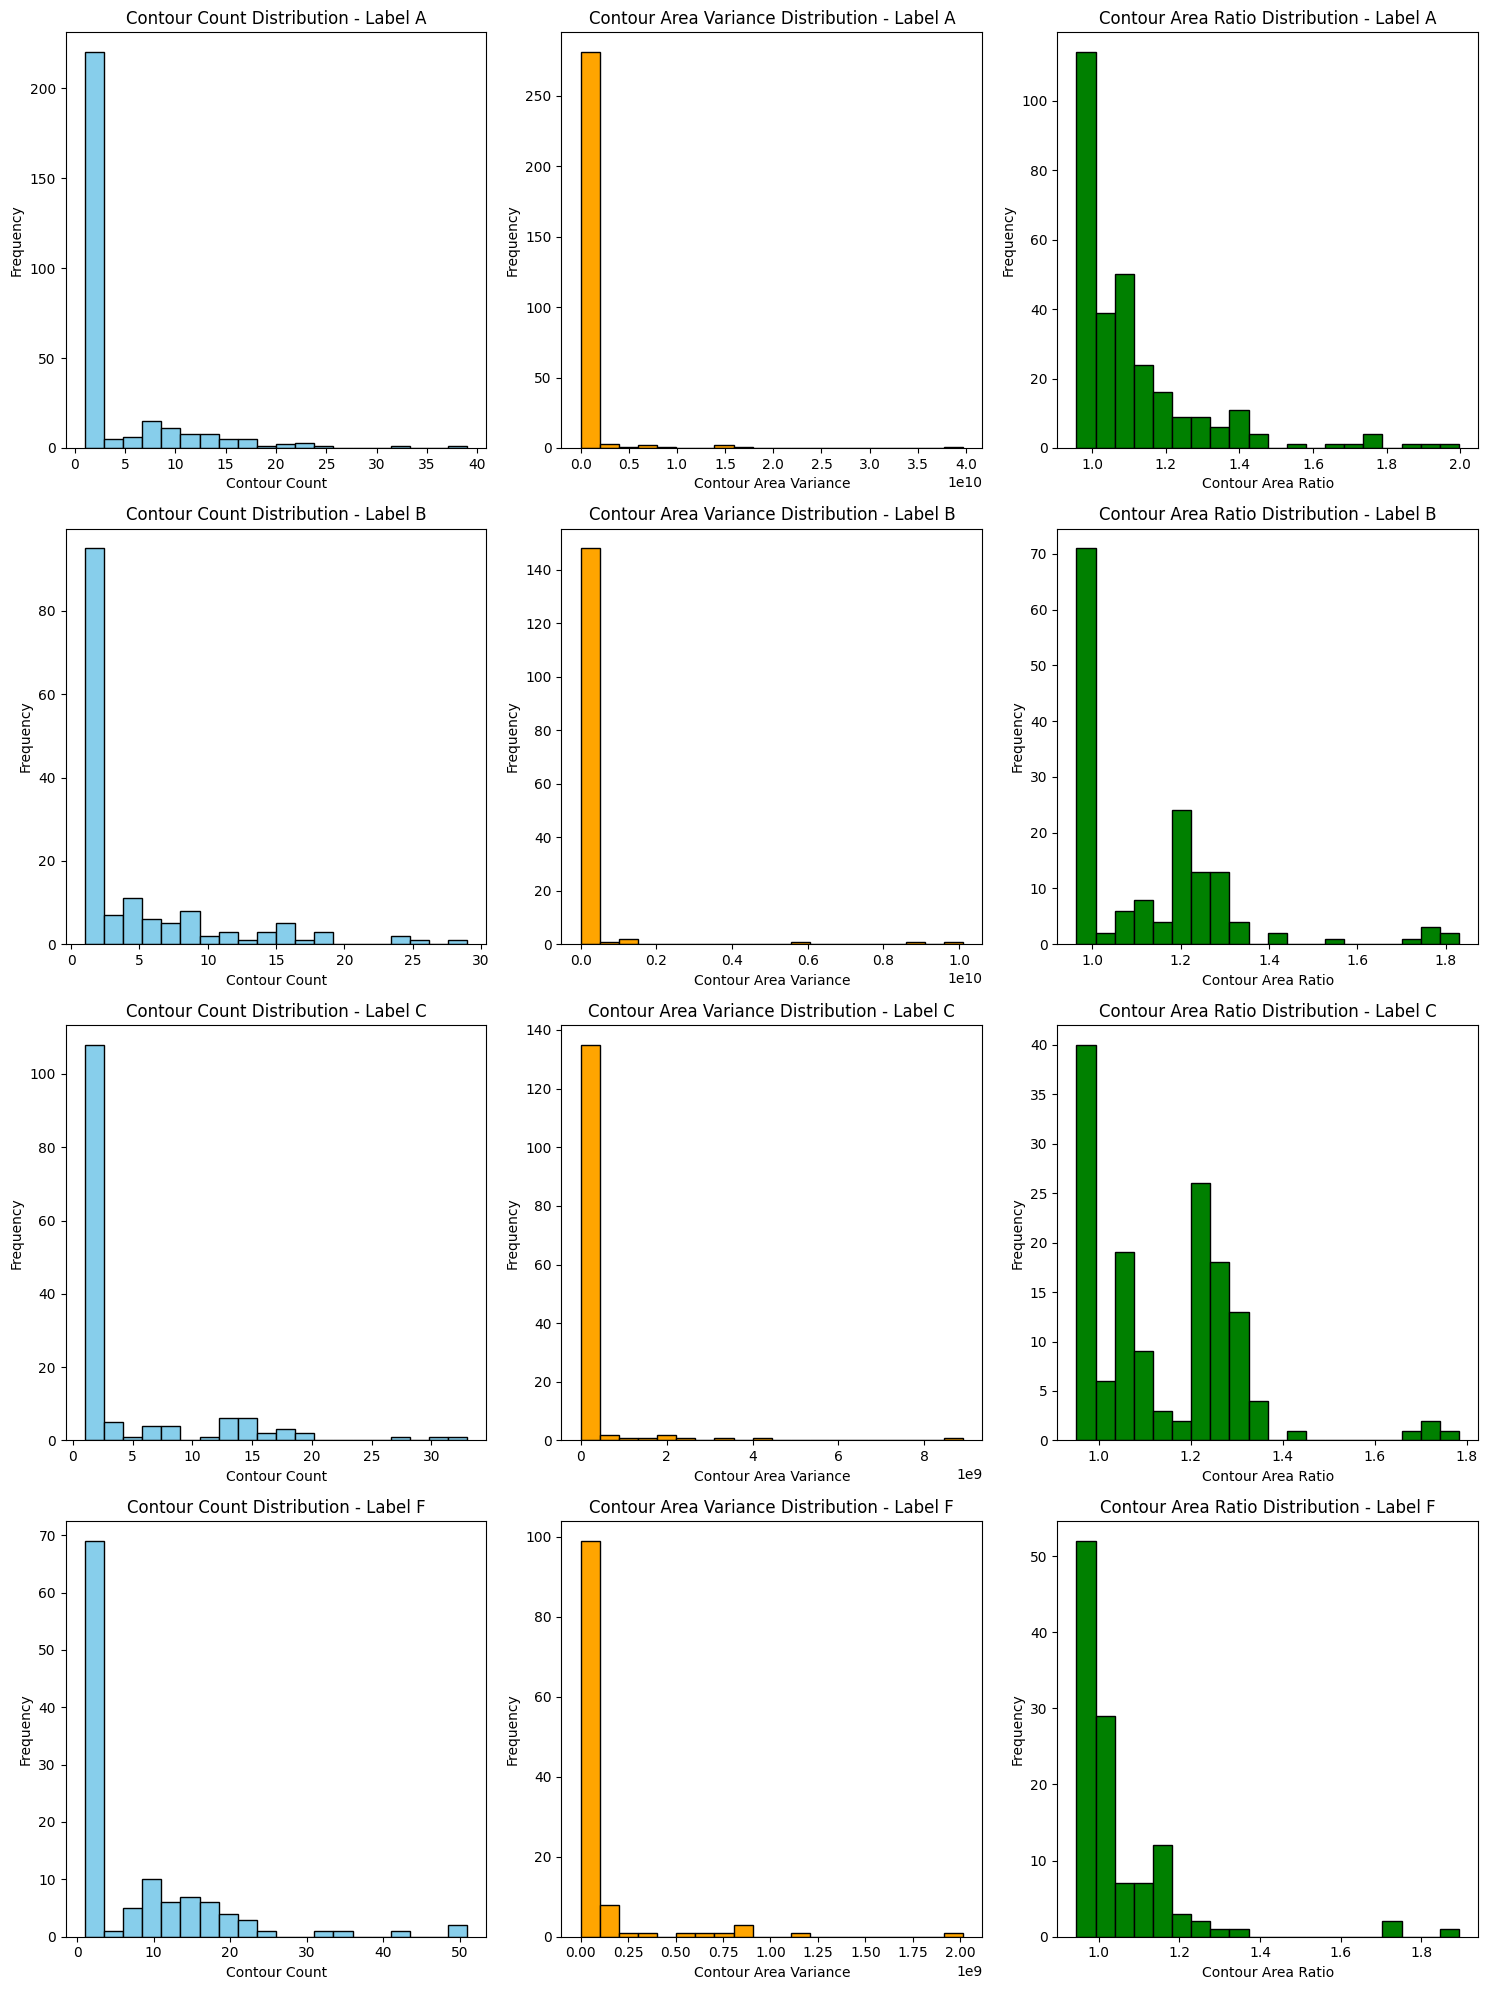

In [236]:
visualize_distribution_by_label(df_results2)